### Super Resolution

In [1]:
from fastai.vision.all import *
from fastai.vision.gan import *

In [2]:
from PIL import ImageDraw

In [3]:
BS = 4
SIZE = 144

In [4]:
# def resize(img, targ_sz, use_min=False):
#     w,h = img.size
#     min_sz = (min if use_min else max)(w,h)
#     ratio = targ_sz/min_sz
#     return int(w*ratio),int(h*ratio)

In [5]:
# class Crappifier():
#     def __init__(self, path_lr, path_hr):
#         self.path_lr = path_lr
#         self.path_hr = path_hr
        
#     def __call__(self, fn):
#         dest = self.path_lr/fn.relative_to(self.path_hr)
#         dest.parent.mkdir(parents=True, exist_ok=True)
#         img = Image.open(fn)
#         targ_sz = resize(img, 144, use_min=True)
#         img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
#         w,h = img.size
#         q = random.randint(10,70)
#         img.save(dest, quality=q)

In [6]:
data_path = Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/Walkwithfastai Data')

In [7]:
path_hr = data_path/'HiRes'
path_lr = data_path/'LowRes'

In [8]:
# items = get_image_files(path_hr)

In [9]:
#parallel(Crappifier(path_lr, path_hr), items)

In [10]:
# bad_im = get_image_files(path_lr)

In [11]:
# im1 = PILImage.create(items[0])
# im2 = PILImage.create(bad_im[0])

In [12]:
# im1.show(); im2.show(figsize=(5,5))

In [13]:
def get_dls(bs:int, size:int):
    dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                       get_items=get_image_files,
                       get_y=lambda x: path_hr/x.name,
                       splitter=RandomSplitter(),
                       item_tfms=Resize(size),
                       batch_tfms=[*aug_transforms(max_zoom=2.),
                                   Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(path_lr, bs=bs, path=data_path, num_workers=0)
    dls.c = 3
    return dls

In [14]:
dls_gen=get_dls(BS, SIZE)

In [15]:
# dls_gen.show_batch(max_n=4, figsize=(12,12))

In [16]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [17]:
bbone = resnet34
def create_gen_learner():
    return unet_learner(dls_gen, bbone, loss_func=loss_gen,
                        blur=True, norm_type=NormType.Weight, self_attention=True, y_range=y_range)

In [18]:
learn_gen = create_gen_learner()

In [19]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

In [20]:
learn_gen.unfreeze()

In [21]:
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3), wd=wd)

In [22]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [23]:
learn_gen.save(data_path/'gen-pre2')

In [24]:
name_gen = 'image_gen'
path_gen = data_path/name_gen

In [25]:
#path_gen.mkdir(exist_ok=True)

In [26]:
# def save_preds(dl, learn):
#     names = dl.dataset.items
    
#     preds,_= learn.get_preds(dl=dl)
#     for i,pred in enumerate(preds):
#         dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
#         arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
#         Image.fromarray(arr).save(path_gen/names[i].name)

In [27]:
# dl = dls_gen.train.new(shuffle=False, drop_last=False, after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [28]:
# preds,_=learn_gen.get_preds(dl=dl)

In [29]:
# preds[0].shape

In [30]:
# preds[0][None].shape

In [31]:
# dec = dl.after_batch.decode((TensorImage(preds[0][None]),))[0][0]

In [32]:
# arr = dec.numpy().transpose(1,2,0)

In [33]:
# plt.imshow(arr.astype(np.uint8))

In [34]:
# save_preds(dl, learn_gen)

In [35]:
path_gen

Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/Walkwithfastai Data/image_gen')

In [36]:
name_gen

'image_gen'

In [37]:
path_g = get_image_files(data_path/name_gen)
path_i = get_image_files(data_path/'HiRes')
fnames = path_g + path_i

In [38]:
fnames[0]

Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/Walkwithfastai Data/image_gen/dt_train_1.jpg')

In [39]:
def get_crit_dls(fnames, bs:int, size:int):
    splits = RandomSplitter(0.1)(fnames)
    dsrc = Datasets(fnames, tfms=[[PILImage.create], [parent_label, Categorize]], splits=splits)
    tfms = [ToTensor(), Resize(size)]
    gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
    return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms, num_workers=0)

In [40]:
dls_crit = get_crit_dls(fnames, bs=BS, size=SIZE)

In [41]:
# dls_crit.show_batch()

In [42]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [43]:
def create_crit_learner(dls, metrics):
    return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_crit)

In [44]:
# learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

In [45]:
# learn_crit.fit_one_cycle(6, 1e-3, wd=wd)

In [46]:
# learn_crit.save(data_path/'critic-pre2')

In [47]:
ls_crit = get_crit_dls(fnames, bs=BS, size=SIZE)

In [48]:
learn_crit = create_crit_learner(dls_crit,metrics=None).load(data_path/'critic-pre2')

In [49]:
learn_gen = create_gen_learner().load(data_path/'gen-pre2')

In [50]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50), show_img=False, 
                                 switcher=FixedGANSwitcher(n_crit=1, n_gen=1),
                   opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.0))


In [51]:
lr = 1e-4

In [52]:
learn.fit(10, lr, wd=wd)

C:\Users\light\anaconda3\envs\mymlenv\lib\site-packages\fastai\callback\core.py:51: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
C:\Users\light\anaconda3\envs\mymlenv\lib\site-packages\fastai\callback\core.py:51: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
C:\Users\light\anaconda3\envs\mymlenv\lib\site-packages\fastai\callback\core.py:51: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,2.173098,3.177468,3.177468,0.622216,04:06
1,2.172745,2.832547,2.832547,0.556002,04:01
2,2.153975,3.126394,3.126394,0.642021,04:01
3,1.977462,3.025384,3.025384,0.616836,04:01
4,2.088833,2.833393,2.833393,0.577194,04:02
5,2.195263,2.848743,2.848743,0.655252,04:02
6,2.172041,3.068028,3.068028,0.739409,04:01
7,2.011951,2.780789,2.780789,0.667495,04:02
8,2.162881,2.960228,2.960228,0.678568,04:01
9,2.088245,2.727011,2.727011,0.584498,04:01


In [54]:
learn.show_results()

### Siamese

In [17]:
from fastai.vision.all import *

In [18]:
src = 'C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/Fruit/train'

In [19]:
items = get_image_files(src)

In [20]:
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).convert('RGB').resize((sz,sz))
    return tensor(array(x)).permute(2,0,1).float()/255.

In [21]:
img1 = resized_image(items[0], 448)
img2 = resized_image(items[1], 448)

In [22]:
class TitledImage(fastuple):
    def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

In [23]:
TitledImage(img1, 'Test').show()

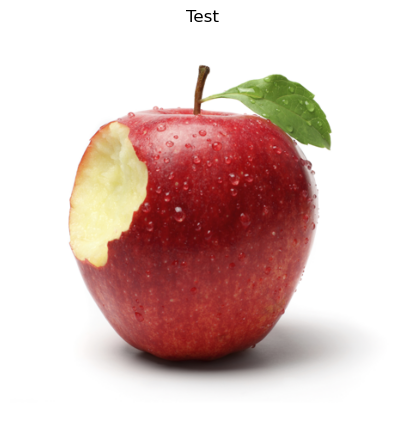

In [24]:
plt.show()

In [25]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs):
        im1, im2, is_same = self
        return show_image(torch.cat([im1,im2], dim=2), title=is_same, ctx=ctx, **kwargs)

In [26]:
SiameseImage(img1, img1, True).show(figsize=(7,7))
SiameseImage(img1, img2, False).show(figsize=(7,7))

<AxesSubplot:title={'center':'False'}>

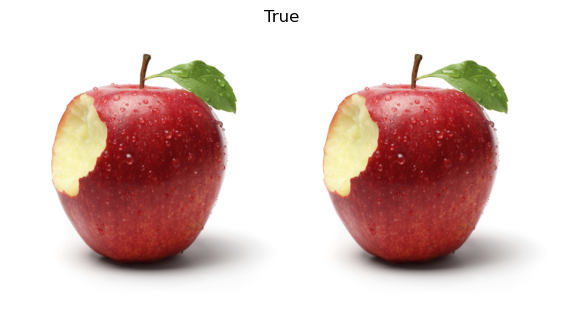

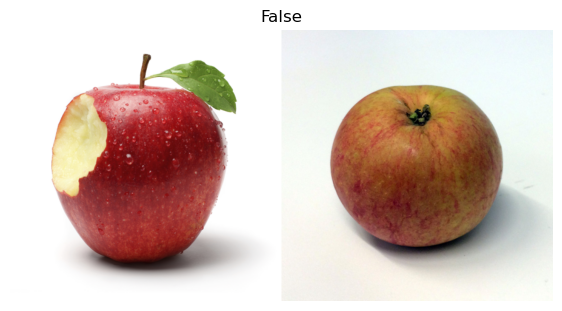

In [27]:
plt.show()

In [10]:
class SiamesePair(Transform):
    def __init__(self, items, labels):
        self.items, self.labels, self.assoc = items,labels,self
        sortlbl = sorted(enumerate(labels), key=itemgetter(1))
        self.clsmap = {k:L(v).itemgot(0) for k,v in itertools.groupby(sortlbl, key=itemgetter(1))}
        self.idxs = range_of(self.items)
    def encodes(self, i):
        othercls = self.clsmap[self.labels[i]] if random.random()>0.5 else self.idxs
        otherit = random.choice(othercls)
        same = tensor([self.labels[otherit]==self.items[i]]).int()
        return SiameseImage(self.items[i], self.items[otherit], same)

In [11]:
labels = [parent_label(o) for o in items]

In [12]:
labels[:5], len(labels)

(['apple', 'apple', 'apple', 'apple', 'apple'], 3581)

In [13]:
sp = SiamesePair(items, labels)

In [14]:
sp.clsmap

{'apple': (#100) [0,1,2,3,4,5,6,7,8,9...],
 'banana': (#98) [100,101,102,103,104,105,106,107,108,109...],
 'beetroot': (#100) [198,199,200,201,202,203,204,205,206,207...],
 'bell pepper': (#100) [298,299,300,301,302,303,304,305,306,307...],
 'cabbage': (#97) [398,399,400,401,402,403,404,405,406,407...],
 'capsicum': (#100) [495,496,497,498,499,500,501,502,503,504...],
 'carrot': (#95) [595,596,597,598,599,600,601,602,603,604...],
 'cauliflower': (#100) [690,691,692,693,694,695,696,697,698,699...],
 'chilli pepper': (#100) [790,791,792,793,794,795,796,797,798,799...],
 'corn': (#99) [890,891,892,893,894,895,896,897,898,899...],
 'cucumber': (#100) [989,990,991,992,993,994,995,996,997,998...],
 'eggplant': (#99) [1089,1090,1091,1092,1093,1094,1095,1096,1097,1098...],
 'garlic': (#100) [1188,1189,1190,1191,1192,1193,1194,1195,1196,1197...],
 'ginger': (#100) [1288,1289,1290,1291,1292,1293,1294,1295,1296,1297...],
 'grapes': (#100) [1388,1389,1390,1391,1392,1393,1394,1395,1396,1397...],
 '

In [15]:
sp.labels

['apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',


In [16]:
OpenAndResize = Transform(resized_image)

In [17]:
pipe = Pipeline([sp, OpenAndResize])

In [18]:
x,y,z = pipe(0)

In [19]:
x.shape, y.shape, z

(torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 tensor([0], dtype=torch.int32))

In [20]:
tls = TfmdLists(range_of(items), pipe)

In [21]:
dls = tls.dataloaders(bs=16, after_batch=[Normalize.from_stats(*imagenet_stats)])

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [22]:
batch = dls.one_batch()

C:\Users\light\anaconda3\envs\mymlenv\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [23]:
a,b,c = batch[0][0], batch[1][0], batch[2][0]

In [24]:
a.shape, b.shape, c

(torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 tensor([0], device='cuda:0', dtype=torch.int32))

In [25]:
from torchvision import transforms

In [26]:
im1 = transforms.ToPILImage()(batch[0][0]).convert("RGB")
im2 = transforms.ToPILImage()(batch[1][0]).convert("RGB")

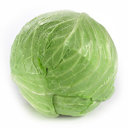

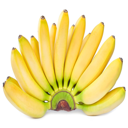

In [27]:
display(im1, im2)

### Audio

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
import matplotlib.pyplot as plt

In [3]:
path_dig = untar_data(URLs.SPEAKERS10, extract_func=tar_extract_at_filename)

In [4]:
audio_extensions[:5]

('.m3u', '.au', '.snd', '.mp3', '.mp2')

In [5]:
fnames = get_files(path_dig, extensions=audio_extensions)

In [6]:
fnames[:5]

(#5) [Path('C:/Users/light/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00001.wav'),Path('C:/Users/light/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00002.wav'),Path('C:/Users/light/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00003.wav'),Path('C:/Users/light/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00004.wav'),Path('C:/Users/light/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00005.wav')]

In [7]:
at = AudioTensor.create(fnames[0])

In [8]:
at, at.shape

(AudioTensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.4414e-04,
          -1.8311e-04, -6.1035e-05]]),
 torch.Size([1, 74880]))

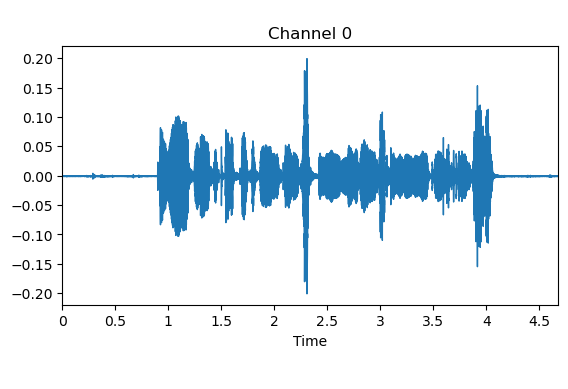

In [9]:
at.show()
plt.show()

In [10]:
cfg = AudioConfig.Voice()

In [11]:
cfg.f_max, cfg.sample_rate

(8000.0, 16000)

In [12]:
aud2spec = AudioToSpec.from_cfg(cfg)

In [13]:
crop1s = ResizeSignal(1000)

In [14]:
pipe = Pipeline([AudioTensor.create, aud2spec])

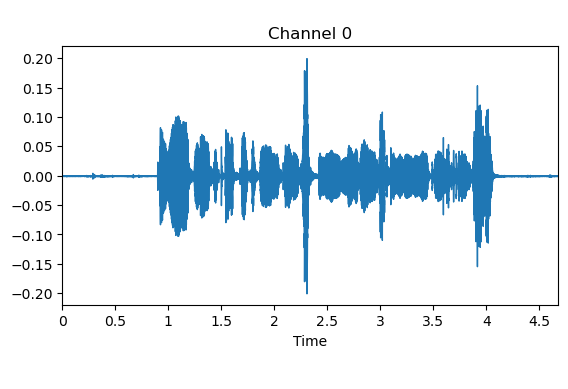

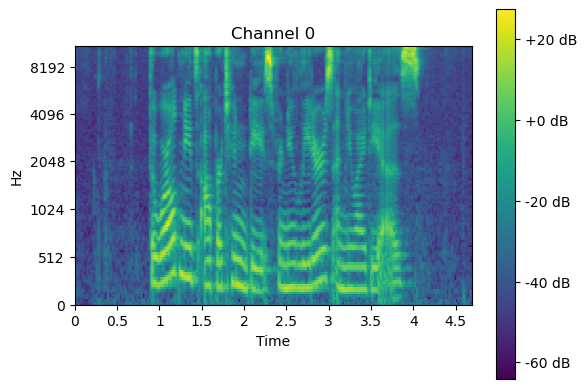

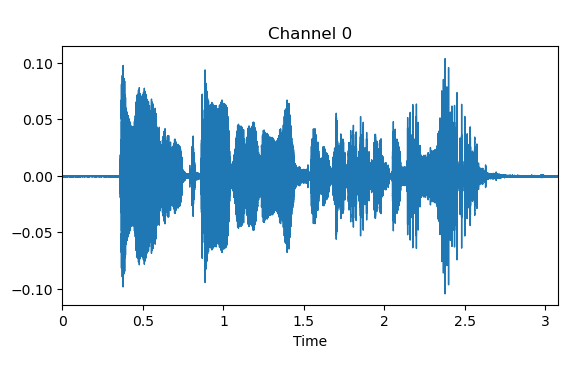

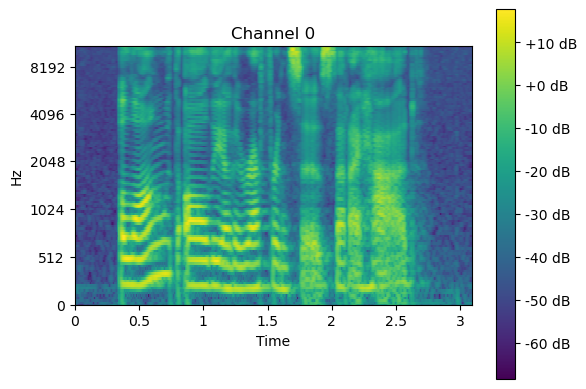

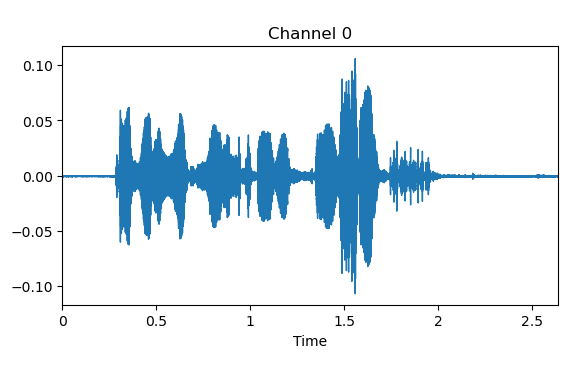

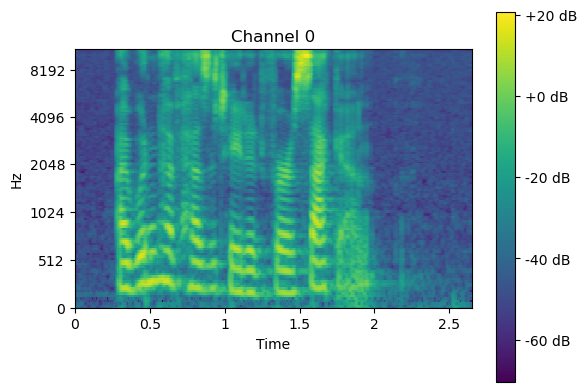

In [15]:
for fn in fnames[:3]:
    audio = AudioTensor.create(fn)
    audio.show()
    pipe(fn).show()
    plt.show()

In [16]:
pipe = Pipeline([AudioTensor.create, crop1s, aud2spec])

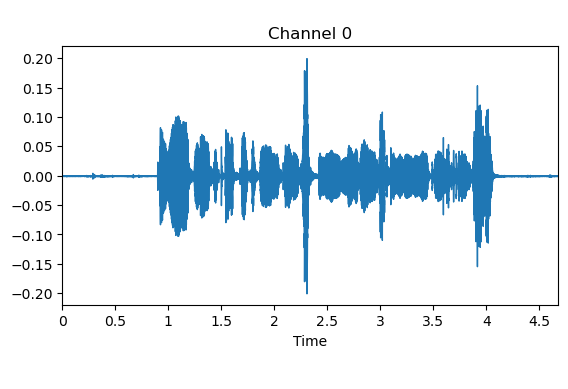

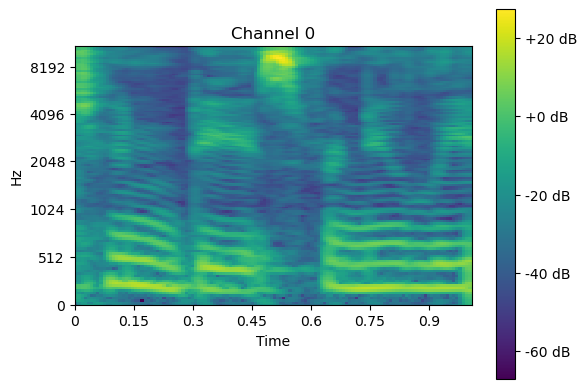

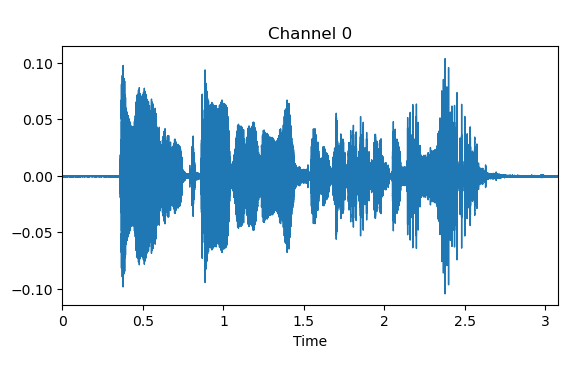

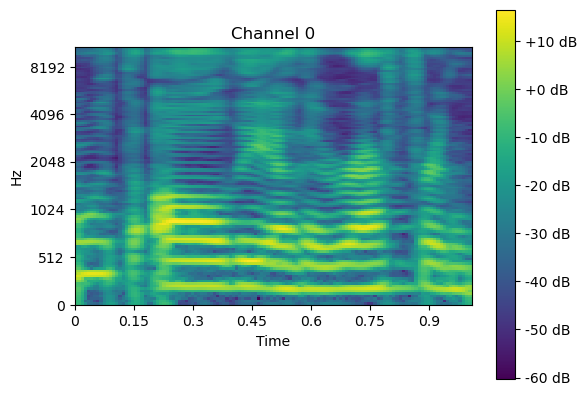

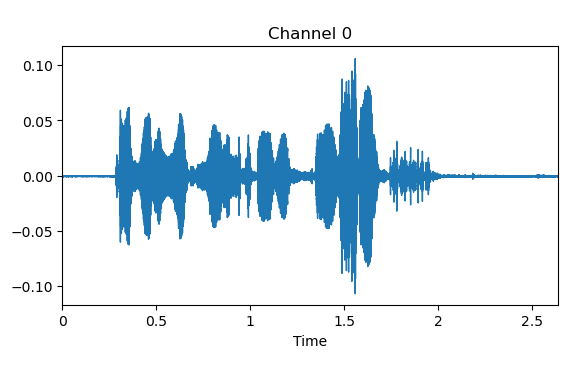

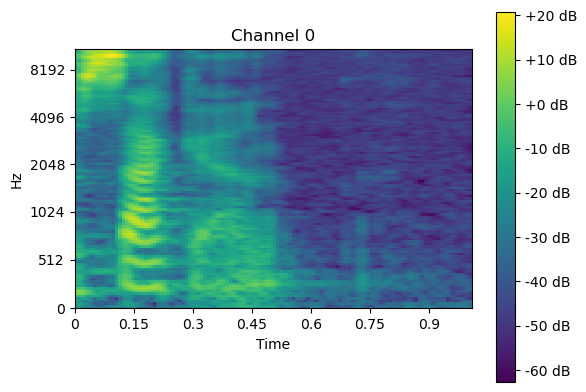

In [17]:
for fn in fnames[:3]:
    audio = AudioTensor.create(fn)
    audio.show()
    pipe(fn).show()
    plt.show()

In [18]:
items_tfms = [ResizeSignal(1000), aud2spec]

In [19]:
get_y = lambda x: x.name[0]

In [20]:
aud_digit = DataBlock(blocks=(AudioBlock, CategoryBlock),
                      get_items=get_audio_files,
                      splitter=RandomSplitter(),
                      item_tfms=items_tfms,
                      get_y=get_y)

In [21]:
dls = aud_digit.dataloaders(path_dig, bs=128, num_workers=0)

In [22]:
dls.show_batch(max_n=3)

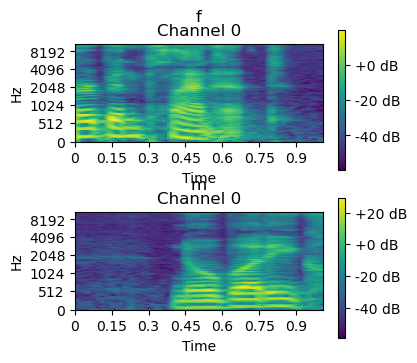

In [23]:
plt.show()

In [24]:
def alter_learner(learn, n_channels=1):
    layer = learn.model[0][0]
    layer.in_channels=n_channels
    layer.weight=nn.Parameter(layer.weight[:,1,:,:].unsqueeze(1))
    learn.model[0][0] = layer

In [25]:
learn = Learner(dls, xresnet18(), CrossEntropyLossFlat(), metrics=accuracy)

In [26]:
n_c = dls.one_batch()[0].shape[1]; n_c

1

In [27]:
alter_learner(learn, n_c)

In [28]:
learn.lr_find()

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.002511886414140463)

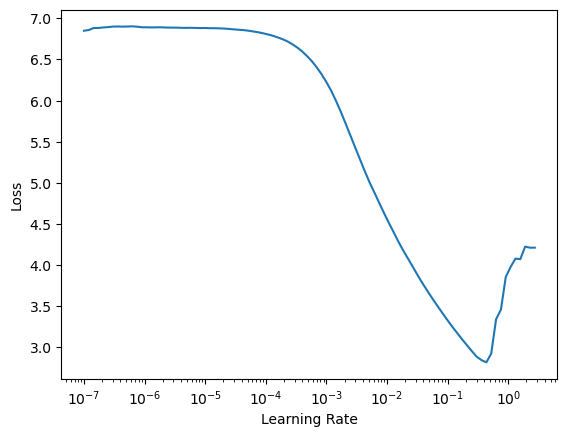

In [29]:
plt.show()

In [30]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.875700,1.124662,0.798177,00:16
1,0.809186,0.107348,0.962240,00:14
2,0.446299,0.753549,0.867188,00:14
3,0.266995,0.125659,0.947917,00:12
4,0.174744,0.040148,0.980469,00:14


In [31]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.034531,0.048236,0.977865,00:13
1,0.032621,0.019963,0.993490,00:13
2,0.029775,0.028440,0.989583,00:13
3,0.026441,0.027517,0.993490,00:13
4,0.023399,0.022450,0.993490,00:13


In [32]:
DBMelSpec=SpectrogramTransformer(mel=True, to_db=True)

In [33]:
aud2spec.settings

{'mel': 'True',
 'to_db': 'False',
 'sample_rate': 16000,
 'n_fft': 1024,
 'win_length': 1024,
 'hop_length': 128,
 'f_min': 50.0,
 'f_max': 8000.0,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctionsClass.hann_window>,
 'power': 2.0,
 'normalized': False,
 'wkwargs': None,
 'center': True,
 'pad_mode': 'reflect',
 'onesided': True,
 'norm': None,
 'stype': 'power',
 'top_db': None,
 'sr': 16000,
 'nchannels': 1}

In [34]:
aud2spec = DBMelSpec(n_mels=128, f_max=10000, n_fft=1024, hop_length=128, top_db=100)

In [35]:
items_tfms = [RemoveSilence(), ResizeSignal(1000), aud2spec, MaskTime(size=4), MaskFreq(size=10)]

In [36]:
aud_digit = DataBlock(blocks=(AudioBlock, CategoryBlock),
                      get_items=get_audio_files,
                      splitter=RandomSplitter(),
                      item_tfms=items_tfms,
                      get_y=get_y)

In [37]:
dls = aud_digit.dataloaders(path_dig, bs=128, num_workers=0)

In [38]:
dls.show_batch(max_n=3)

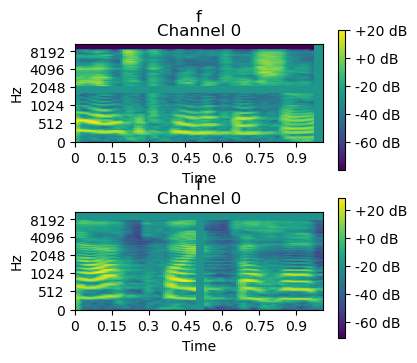

In [39]:
plt.show()

In [40]:
def audio_learner(dls, arch, loss_func, metrics):
    learn = Learner(dls, arch, loss_func, metrics=metrics)
    n_c = dls.one_batch()[0].shape[1]
    if n_c == 1: alter_learner(learn)
    return learn

In [41]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

In [42]:
learn.lr_find()

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.0020892962347716093)

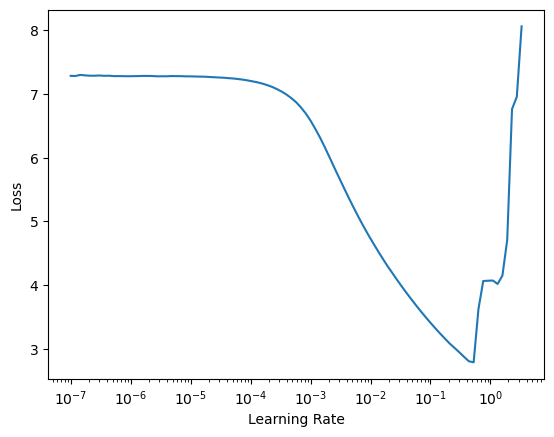

In [43]:
plt.show()

In [44]:
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.667038,0.603295,0.954427,00:28
1,1.870669,5.113060,0.445312,00:29
2,0.949219,0.404155,0.854167,00:28
3,0.532037,0.026539,0.988281,00:27
4,0.314324,0.009618,0.998698,00:29
5,0.189743,0.011151,0.994792,00:28
6,0.116336,0.008517,0.997396,00:28
7,0.073635,0.010614,0.996094,00:27
8,0.046444,0.003391,0.998698,00:28
9,0.031023,0.005547,0.998698,00:27


In [45]:
learn.fit_one_cycle(10, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.003151,0.004293,0.997396,00:29
1,0.003016,0.006886,0.997396,00:27
2,0.003637,0.006014,0.998698,00:27
3,0.004406,0.003143,1.000000,00:26
4,0.004256,0.009108,0.997396,00:27
5,0.004439,0.007191,0.998698,00:29
6,0.004079,0.006782,0.997396,00:25
7,0.003940,0.001722,1.000000,00:26
8,0.003399,0.005367,0.997396,00:25
9,0.003105,0.002162,1.000000,00:25


In [46]:
aud2mfcc = AudioToMFCC(n_mfcc=40, melkwargs={'n_fft':2048, 'hop_length':256, 'n_mels': 128})

In [47]:
items_tfms =[ResizeSignal(1000), aud2mfcc]

In [49]:
aud_digit.item_tfms

(#8) [ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: ,Resample:
encodes: (AudioTensor,object) -> encodes
decodes: ,DownmixMono:
encodes: (AudioTensor,object) -> encodes
decodes: ,RemoveSilence:
encodes: (AudioTensor,object) -> encodes
decodes: ,ResizeSignal:
encodes: (AudioTensor,object) -> encodes
decodes: ,AudioToSpec:
encodes: (AudioTensor,object) -> encodes
decodes: ,MaskTime:
encodes: (AudioSpectrogram,object) -> encodes
(AudioTensor,object) -> encodes
decodes: ,MaskFreq:
encodes: (AudioSpectrogram,object) -> encodes
(AudioTensor,object) -> encodes
decodes: ]

In [50]:
aud_digit.item_tfms = items_tfms

In [52]:
dls = aud_digit.dataloaders(path_dig, bs=128, num_workers=0)

In [53]:
dls.show_batch(max_n=3)

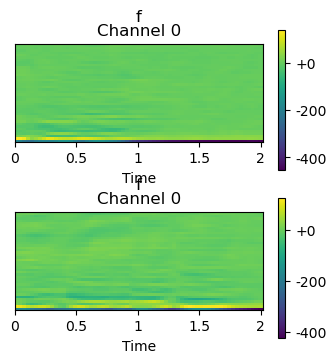

In [54]:
plt.show()

In [55]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

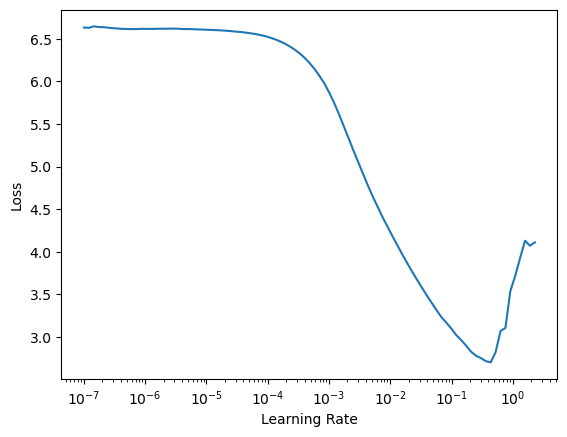

In [56]:
learn.lr_find()
plt.show()

In [57]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.647706,0.456117,0.864583,00:12
1,0.676760,0.255182,0.920573,00:12
2,0.365149,0.121018,0.963542,00:12
3,0.216877,0.024066,0.989583,00:12
4,0.137045,0.014578,0.996094,00:12


In [58]:
items_tfms =[ResizeSignal(1000), aud2mfcc, Delta()]

In [59]:
aud_digit.item_tfms = items_tfms

In [60]:
dls = aud_digit.dataloaders(path_dig, bs=128, num_workers=0)

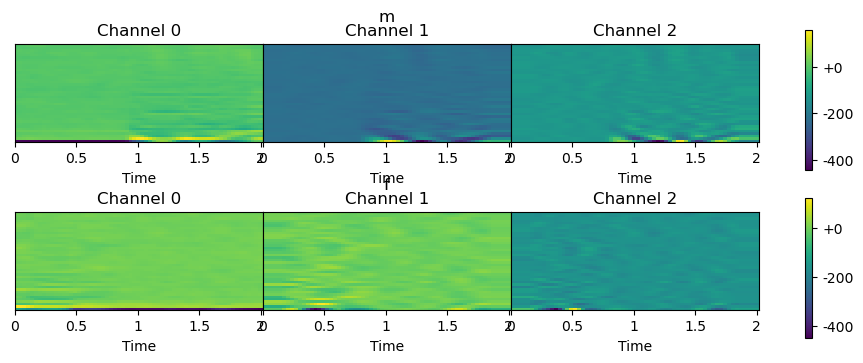

In [61]:
dls.show_batch(max_n=3)
plt.show()

In [62]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

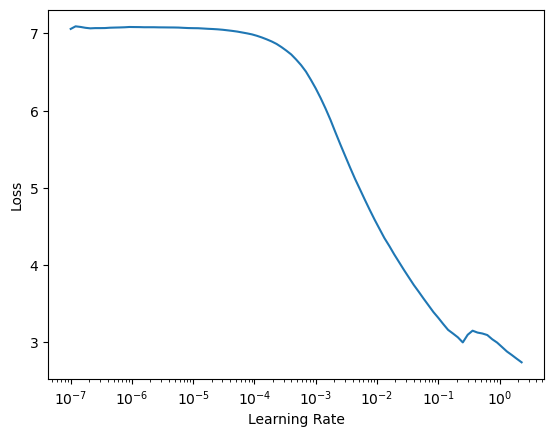

In [63]:
learn.lr_find()
plt.show()

In [64]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.775303,2.899335,0.660156,00:18
1,0.737338,0.086976,0.964844,00:18
2,0.387638,0.064280,0.985677,00:19
3,0.227839,0.075526,0.968750,00:18
4,0.141391,0.033443,0.990885,00:18


In [65]:
learn.fit_one_cycle(5, 1e-2/10)

epoch,train_loss,valid_loss,accuracy,time
0,0.017510,0.019050,0.992188,00:19
1,0.023205,0.029974,0.988281,00:18
2,0.020327,0.014746,0.996094,00:18
3,0.017258,0.021309,0.994792,00:18
4,0.017996,0.041921,0.989583,00:18
